In [139]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
warnings.filterwarnings('ignore')

In [140]:
def my_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

def gs_regressor_params(parameters ={}, check_parameter={}, metric="accuracy", reg=None, n_splits=1, test_size=0.20):
    metric = make_scorer(my_accuracy)
    cv = TimeSeriesSplit(n_splits=n_splits)
    gs_reg = GridSearchCV(reg, parameters, cv=cv, scoring=metric, return_train_score=True, verbose=False)
    gs_reg.fit(X_train,y_train)
    plot_gs_results(gs_model=gs_reg, params=parameters, check_params = check_parameter, model_name=str(reg))

In [141]:
def loss_function(res, pred):
    return (pred[0] - res) ** 2 + (pred[1] - abs(res - 1)) ** 2

def aggregate(res, pred_df, loss_func = loss_function, weights = None, m = 2):
    val = df.values.transpose()
    pred = np.array(list(map(lambda x : np.array(list(map(list, x))), val)))
    T = len(res)
    K = len(pred)
    res_df = pd.DataFrame()
    names = df.columns
    for i in range(K):
        res_df[names[i] + '_mean'] = np.zeros(T)
        res_df[names[i] + '_mean_100'] = np.zeros(T)
        res_df[names[i] + '_accumulated'] = np.zeros(T)
        res_df[names[i] + '_weight'] = np.zeros(T)
    res_df['composition_mean'] = np.zeros(T)
    res_df['composition_mean_100'] = np.zeros(T)
    res_df['composition_accumulated'] = np.zeros(T)
    if not weights:
        weights = np.full(K, 1/K)
    agg_pred = np.zeros(2 * T).reshape(T, 2)
    for t in range(1, T):
        gamma = pred[:,t]
        def G(omega):
            return -np.log(np.inner(weights, np.exp(-loss_func(omega, np.transpose(gamma)))))
        ''' = (G(0) + G(1)) / 2 + 1  #Срезка, а не модуль
        s2 = (G(0) + G(1)) / 2 - 1
        if s1 > G(0) and s1 > G(1):
            s = s1
        if s2 < G(0) and s2 < G(1):
            s = s2'''
        delta = abs(G(1) - G(0))
        if (delta >= m):
            s = min(G(1), G(0)) + m
        else:
            s = (m + G(0) + G(1)) / 2
        #print(max(s - G(0), 0) + max(s - G(1), 0), G(0), G(1), delta, s)
        weights = (weights * np.exp(-loss_func(res[t], np.transpose(gamma))))
        weights /= np.sum(weights)
        agg_pred[t] = np.array([abs(s - G(1)) / 2, abs(s - G(0)) / 2])
        agg_pred[t] = agg_pred[t]
        for i in range(K):
            res_df[names[i]+'_accumulated'][t] = res_df[names[i]+'_accumulated'][t - 1] + loss_func(res[t], gamma[i])
            res_df[names[i]+'_mean'][t] = res_df[names[i]+'_accumulated'][t] / t
            res_df[names[i] + '_weight'][t] = weights[i]
            if t > 100:
                res_df[names[i]+'_mean_100'][t] = (res_df[names[i]+'_accumulated'][t] - res_df[names[i]+'_accumulated'][t - 100]) / 100
            else:
                res_df[names[i]+'_mean_100'][t] = res_df[names[i]+'_mean'][t]
        res_df['composition_accumulated'][t] = res_df['composition_accumulated'][t - 1] + loss_func(res[t], agg_pred[t])
        res_df['composition_mean'][t] = res_df['composition_accumulated'][t] / t
        if t > 100:
            res_df['composition_mean_100'][t] = (res_df['composition_accumulated'][t] - res_df['composition_accumulated'][t - 100]) / 100
        else:
            res_df['composition_mean_100'][t] = res_df['composition_mean'][t]
    res_df['composition_k1'] = agg_pred.transpose()[0]
    res_df['composition_k2'] = agg_pred.transpose()[1]
    return res_df

In [142]:
data = pd.read_pickle('final_data.pkl')
#data = pd.read_pickle('books&user.pkl')
#data = pd.read_csv('egor_noob.csv', encoding='utf-8')
print(data.shape)
data.head(1)

(34588, 132)


,,,Surface,hour,round,p1_win,p1_age,p2_age,k1,k2,p1_height,p2_height,...,p2_filter_lag_1_receiver_points_won_match__mean_28,p2_filter_lag_1_receiver_points_won_match__median_28,p1_lag_1_match_duration_mnt_mean_28,p1_lag_1_match_duration_mnt_median_28,p1_filter_lag_1_match_duration_mnt_mean_28,p1_filter_lag_1_match_duration_mnt_median_28,p2_lag_1_match_duration_mnt_mean_28,p2_lag_1_match_duration_mnt_median_28,p2_filter_lag_1_match_duration_mnt_mean_28,p2_filter_lag_1_match_duration_mnt_median_28
date,p1,p2,,,,,,,,,,,,,,,,,,,,,
2015-06-01,Gasquet R.,Djokovic N.,0.0,18,1.0,0,28.046575,28.972603,19.0,1.0,1.88,1.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [144]:
X_test = X[(date_idx >= '2018-01-01') & (date_idx < '2020-01-01')]
y_test = y[(date_idx >= '2019-01-01') & (date_idx < '2020-01-01')]
X_train = X[(date_idx < '2018-01-01')]
y_train = y[(date_idx < '2018-01-01')]

In [145]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.4],
    'colsample_bytree': [0.8],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
}
metric = make_scorer(my_accuracy)
cv = TimeSeriesSplit(n_splits=10)
gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
model = gs_reg.fit(X_train,y_train)


In [146]:
xgpred_upgrade_180 = np.zeros(180000 * 2).reshape(180000, 2)
days=180
date = datetime.datetime(2018, 1, 1)
start = 0
for i in range(4):
    start_time = time.time()
    wall = date.strftime("%Y-%m-%d")
    XX_test180 = X[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    yy_test180 = y[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    XX_train180 = X[(date_idx < wall)]
    yy_train180 = y[(date_idx < wall)]
    if XX_test180.shape[0] != 0:
        metric180 = make_scorer(my_accuracy)
        cv180 = TimeSeriesSplit(n_splits=10)
        week_gs_reg180 = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv180, scoring=metric180, return_train_score=True, verbose=False)
        week_model180 = week_gs_reg180.fit(XX_train180,yy_train180)
        week_xgpred180 = np.array(list(map(lambda x: np.array([x[1], x[0]]), week_model180.predict_proba(XX_test180))))
        xgpred_upgrade_180[start:start+XX_test180.shape[0]] = week_xgpred180
        start += XX_test180.shape[0]
    print(date.strftime("%Y-%m-%d") , time.time() - start_time, 'seconds')
    date += datetime.timedelta(days=days)
xgpred_upgrade_180 = xgpred_upgrade_180[:start]

2018-01-01 23.69333004951477 seconds
2018-06-30 31.348748922348022 seconds
2018-12-27 36.820350885391235 seconds
2019-06-25 45.13292980194092 seconds


In [147]:
xgpred_upgrade_360 = np.zeros(360000 * 2).reshape(360000, 2)
days=360
date = datetime.datetime(2018, 1, 1)
start = 0
for i in range(2):
    start_time = time.time()
    wall = date.strftime("%Y-%m-%d")
    XX_test360 = X[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    yy_test360 = y[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    XX_train360 = X[(date_idx < wall)]
    yy_train360 = y[(date_idx < wall)]
    if XX_test360.shape[0] != 0:
        metric360 = make_scorer(my_accuracy)
        cv360 = TimeSeriesSplit(n_splits=10)
        week_gs_reg360 = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv360, scoring=metric360, return_train_score=True, verbose=False)
        week_model360 = week_gs_reg360.fit(XX_train360,yy_train360)
        week_xgpred360 = np.array(list(map(lambda x: np.array([x[1], x[0]]), week_model360.predict_proba(XX_test360))))
        xgpred_upgrade_360[start:start+XX_test360.shape[0]] = week_xgpred360
        start += XX_test360.shape[0]
    print(date.strftime("%Y-%m-%d") , time.time() - start_time, 'seconds')
    date += datetime.timedelta(days=days)
xgpred_upgrade_360 = xgpred_upgrade_360[:start]

2018-01-01 23.505149602890015 seconds
2018-12-27 36.81131291389465 seconds


In [148]:
print(X_test.shape)
print(xgpred_upgrade_180.shape)
print(xgpred_upgrade_360.shape)

(13816, 131)
(13816, 2)
(13816, 2)


In [153]:
#xgpred_upgrade_30 = xgpred_upgrade_30[:xgpred_upgrade_7.shape[0]]
#xgpred_upgrade_14 = xgpred_upgrade_14[:xgpred_upgrade_7.shape[0]]
dff = data[(date_idx >= '2018-01-01') & (date_idx < '2020-01-01')]
dff = dff[:xgpred_upgrade_7.shape[0]]
res = np.array(dff['p1_win'])

k1 = 1 / np.array(dff['k1'])
k2 = 1 / np.array(dff['k2'])
cfs = np.array([k1, k2])
cfs[0] /= (k1 + k2)
cfs[1] /= (k1 + k2)
cfs = cfs.transpose()

xgpred = np.array(list(map(lambda x: np.array([x[1], x[0]]), model.predict_proba(X_test))))
pred = np.array([cfs, xgpred, xgpred_upgrade_180, xgpred_upgrade_360])
pred_list = list(map(lambda x : list(map(list, x)), pred))
df = pd.DataFrame(pred_list).transpose()
df.columns=['cfs', 'xgpred', 'xgpred_upgrade_180', 'xgpred_upgrade_360']

In [154]:
df

,cfs,xgpred,xgpred_upgrade_180,xgpred_upgrade_360
0,"[0.5585106382978724, 0.4414893617021276]","[0.54949951171875, 0.45050048828125]","[0.54949951171875, 0.45050048828125]","[0.54949951171875, 0.45050048828125]"
1,"[0.6076923076923076, 0.39230769230769225]","[0.5790133476257324, 0.4209866523742676]","[0.5790133476257324, 0.4209866523742676]","[0.5790133476257324, 0.4209866523742676]"
2,"[0.6076923076923076, 0.39230769230769225]","[0.579552948474884, 0.42044705152511597]","[0.579552948474884, 0.42044705152511597]","[0.579552948474884, 0.42044705152511597]"
3,"[0.3119266055045871, 0.6880733944954128]","[0.3356999158859253, 0.6643000841140747]","[0.3356999158859253, 0.6643000841140747]","[0.3356999158859253, 0.6643000841140747]"
4,"[0.6880733944954128, 0.3119266055045871]","[0.6589162349700928, 0.3410837650299072]","[0.6589162349700928, 0.3410837650299072]","[0.6589162349700928, 0.3410837650299072]"
...,...,...,...,...
13811,"[0.4109947643979057, 0.5890052356020942]","[0.4437040686607361, 0.5562959313392639]","[0.431781142950058, 0.5682188272476196]","[0.4349119961261749, 0.5650880336761475]"
13812,"[0.5, 0.5]","[0.5006402730941772, 0.49935972690582275]","[0.5057856440544128, 0.49421435594558716]","[0.5021445751190186, 0.49785542488098145]"
13813,"[0.5, 0.5]","[0.5078954696655273, 0.49210453033447266]","[0.5079405903816223, 0.4920594096183777]","[0.5053356885910034, 0.4946643114089966]"
13814,"[0.375, 0.625]","[0.38884443044662476, 0.6111555695533752]","[0.38936492800712585, 0.6106350421905518]","[0.39162084460258484, 0.6083791255950928]"


In [155]:
agg = aggregate(res, df)

In [156]:
agg

,cfs_mean,cfs_mean_100,cfs_accumulated,cfs_weight,xgpred_mean,xgpred_mean_100,xgpred_accumulated,xgpred_weight,xgpred_upgrade_180_mean,xgpred_upgrade_180_mean_100,...,xgpred_upgrade_180_weight,xgpred_upgrade_360_mean,xgpred_upgrade_360_mean_100,xgpred_upgrade_360_accumulated,xgpred_upgrade_360_weight,composition_mean,composition_mean_100,composition_accumulated,composition_k1,composition_k2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.307811,0.307811,0.307811,0.258848,0.354460,0.354460,0.354460,2.470506e-01,0.354460,0.354460,...,2.470506e-01,0.354460,0.354460,0.354460,2.470506e-01,0.342164,0.342164,0.342164,0.586336,0.413577
2,0.307811,0.307811,0.615621,0.267720,0.354005,0.354005,0.708011,2.440934e-01,0.354005,0.354005,...,2.440934e-01,0.354005,0.354005,0.708011,2.440934e-01,0.341626,0.341626,0.683253,0.586986,0.412927
3,0.270073,0.270073,0.810218,0.273799,0.311133,0.311133,0.933400,2.420668e-01,0.311133,0.311133,...,2.420668e-01,0.311133,0.311133,0.933400,2.420668e-01,0.300030,0.300030,0.900089,0.329220,0.670682
4,0.251204,0.251204,1.004814,0.281436,0.291519,0.291519,1.166076,2.395214e-01,0.291519,0.291519,...,2.395214e-01,0.291519,0.291519,1.166076,2.395214e-01,0.280465,0.280465,1.121860,0.666931,0.332921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13811,0.416819,0.443146,5756.682319,1.000000,0.418875,0.445194,5785.076135,4.663611e-13,0.418763,0.442334,...,2.188401e-12,0.418729,0.444680,5783.069157,3.470100e-12,0.416851,0.443146,5757.123744,0.410995,0.589005
13812,0.416825,0.447652,5757.182319,1.000000,0.418880,0.449556,5785.574856,4.669583e-13,0.418768,0.446641,...,2.213723e-12,0.418735,0.449018,5783.564877,3.484983e-12,0.416857,0.447652,5757.623744,0.500000,0.500000
13813,0.416831,0.452157,5757.682319,1.000000,0.418887,0.454033,5786.090771,4.595852e-13,0.418775,0.451211,...,2.178569e-12,0.418741,0.453509,5784.075605,3.447795e-12,0.416863,0.452157,5758.123744,0.500000,0.500000
13814,0.416857,0.459129,5758.463569,1.000000,0.418911,0.460624,5786.837793,4.755881e-13,0.418798,0.457791,...,2.257297e-12,0.418765,0.460036,5784.815856,3.592092e-12,0.416889,0.459129,5758.904994,0.375000,0.625000


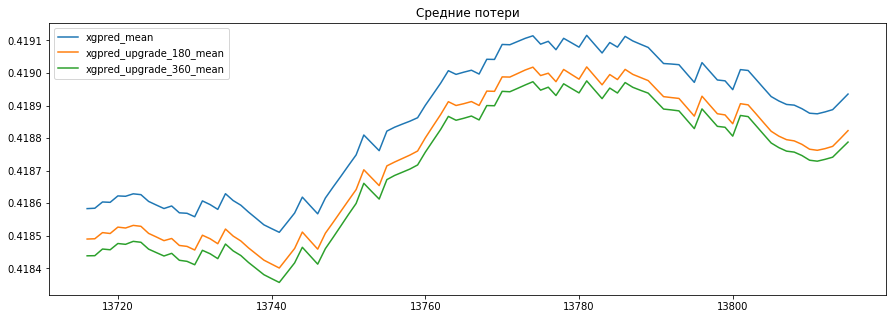

In [164]:
agg[['xgpred_mean', 'xgpred_upgrade_180_mean', 'xgpred_upgrade_360_mean']].tail(100).plot(figsize=(15, 5), title='Средние потери')

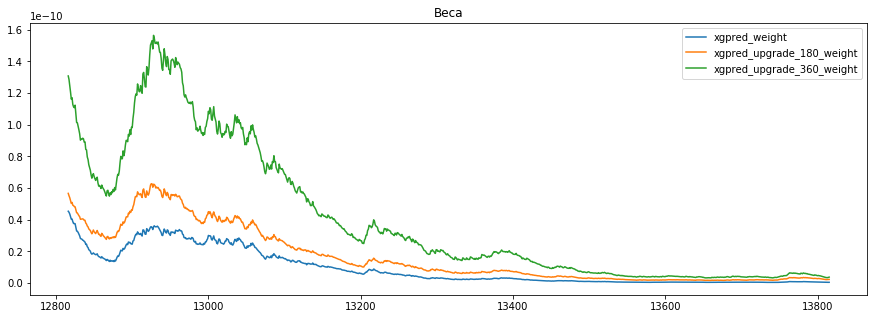

In [162]:
agg[['xgpred_weight', 'xgpred_upgrade_180_weight', 'xgpred_upgrade_360_weight']].tail(1000).plot(figsize=(15, 5), title='Веса')